In [1]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# Import libraries
import numpy as np
import sep
from astropy.io import fits

# 1. Define the file list
image_files = [
   "fits_5(main).fits",  
    "fits_1.fits",
    "fits_2.fits",
    "fits_3.fits",
    "fits_4.fits",
    "fits_6.fits"   
]

data = fits.open("fits_5(main).fits")['SCI'].data.astype(float)

In [2]:
# additional setup for reading the test image and displaying plots

import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [3]:
# Load JWST FITS image
hdu = fits.open("fits_5(main).fits")
hdu.info()  # Optional: to inspect structure

data = hdu[0].data  # Use the only available HDU

Filename: fits_5(main).fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (14339, 8582)   float32   


In [4]:
data = data.byteswap().view(data.dtype.newbyteorder('='))
  # Ensure endian compatibility
bkg = sep.Background(data)
data_sub = data - bkg

In [5]:
sep.set_extract_pixstack(2000000)
objects = sep.extract(data_sub, thresh=3.0, err=bkg.globalrms)
print("Number of sources found:", len(objects))

Number of sources found: 20009


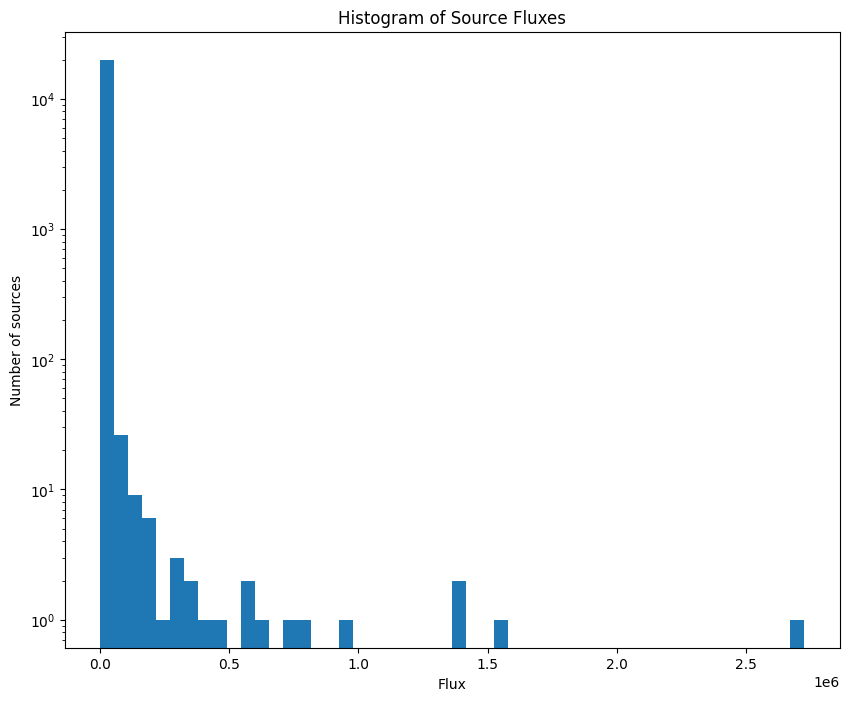

In [6]:
fluxes = np.array([obj['flux'] for obj in objects])
plt.hist(fluxes, bins=50, log=True)
plt.xlabel('Flux')
plt.ylabel('Number of sources')
plt.title('Histogram of Source Fluxes')
plt.savefig("flux_histogram.png", dpi=300)
plt.show()

In [7]:
plt.savefig("fits_5_main_fits.png")


<Figure size 1000x800 with 0 Axes>

In [8]:
objects = sep.extract(data_sub, thresh=2.5, err=bkg.globalrms)

In [9]:
fluxes = objects['flux']

In [10]:
import numpy as np
mean_flux = np.mean(fluxes)
median_flux = np.median(fluxes)
std_flux = np.std(fluxes)

print("Mean flux:", mean_flux)
print("Median flux:", median_flux)
print("Standard deviation:", std_flux)

Mean flux: 1406.3252404489988
Median flux: 10.2493257522583
Standard deviation: 35438.18662485652


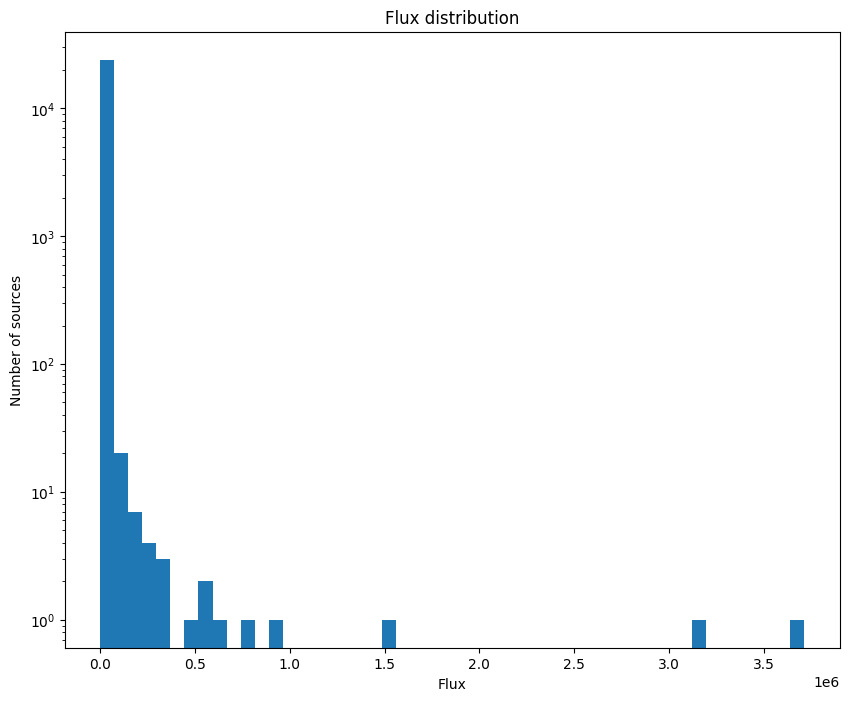

In [11]:
import matplotlib.pyplot as plt

plt.hist(fluxes, bins=50, log=True)
plt.xlabel("Flux")
plt.ylabel("Number of sources")
plt.title("Flux distribution")
plt.savefig("flux_histogram.png")
plt.show()


In [12]:
max_flux = np.max(fluxes)
outlier_index = np.argmax(fluxes)
outlier = objects[outlier_index]

# How many standard deviations away
n_sigma = (max_flux - mean_flux) / std_flux

print("Largest flux:", max_flux)
print(f"Largest outlier is {n_sigma:.2f} standard deviations from the mean")


Largest flux: 3712427.5
Largest outlier is 104.72 standard deviations from the mean


In [13]:
x_pos = outlier['x']
y_pos = outlier['y']

print(f"Outlier position: x = {x_pos}, y = {y_pos}")

Outlier position: x = 13181.842261530928, y = 779.2429504381288


In [14]:

from reproject import reproject_interp

# 1. List of JWST image filenames
image_files = [
     "fits_5(main).fits",  # blue
    "fits_1.fits",
    "fits_2.fits",
    "fits_3.fits",      #green
    "fits_4.fits",
    "fits_6.fits"   # red
]

In [15]:
# 2. Reference image (for WCS alignment)
ref_file = image_files[0]
with fits.open(ref_file) as hdul:
    ref_header = hdul['SCI'].header
    ref_shape = hdul['SCI'].data.shape

In [16]:
# 3. Reproject all images to reference WCS
reprojected_images = []
for fname in image_files:
    with fits.open(fname) as hdul:
        data = hdul['SCI'].data
        header = hdul['SCI'].header
        array, _ = reproject_interp((data, header), ref_header, shape_out=ref_shape)
        reprojected_images.append(array)

In [17]:

# 4. Assign RGB channels (you can experiment with combinations)
r = reprojected_images[5]  # f444w
g = reprojected_images[3]  # f200w
b = reprojected_images[0]  # f090w

In [18]:
# 5. Normalize function
def normalize(img, stretch=0.01):
    img = img - np.nanmin(img)
    maxval = np.nanpercentile(img, 100 * (1 - stretch))
    img = img / maxval
    img = np.clip(img, 0, 1)
    return img

In [19]:
# 6. Normalize RGB
r_norm = normalize(r)
g_norm = normalize(g)
b_norm = normalize(b)

In [20]:
# 7. Combine into RGB
rgb = np.dstack([r_norm, g_norm, b_norm])

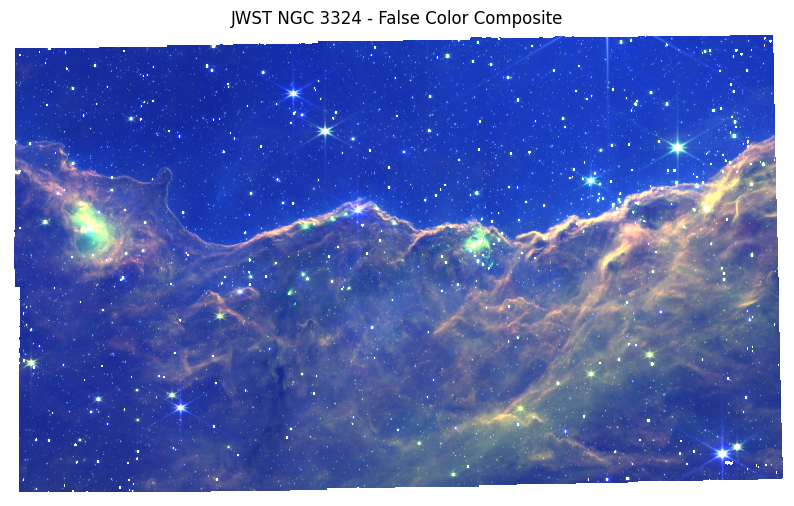

In [21]:
# 8. Display and save
plt.figure(figsize=(10, 10))
plt.imshow(rgb, origin='lower')
plt.axis('off')
plt.title("JWST NGC 3324 - False Color Composite")
plt.savefig("NGC_3324_false_color_reprojected.png", dpi=300, bbox_inches='tight')
plt.show()